In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/Chicago_Crimes_2012_to_2017.csv')

In [ ]:
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05-03-2016 23:40,013XX S SAWYER AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05-10-2016 15:56,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05-03-2016 21:40,061XX S DREXEL AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05-10-2016 15:56,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05-03-2016 23:31,053XX W CHICAGO AVE,470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,...,37.0,25.0,24,1140789.0,1904819.0,2016,05-10-2016 15:56,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05-03-2016 22:10,049XX W FULTON ST,460,BATTERY,SIMPLE,SIDEWALK,False,...,28.0,25.0,08B,1143223.0,1901475.0,2016,05-10-2016 15:56,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05-03-2016 22:00,003XX N LOTUS AVE,820,THEFT,$500 AND UNDER,RESIDENCE,False,...,28.0,25.0,6,1139890.0,1901675.0,2016,05-10-2016 15:56,41.886297,-87.761751,"(41.886297242, -87.761750709)"


In [ ]:
columns_to_drop = ['Case Number', 'IUCR', 'FBI Code', 'Unnamed: 0']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print("Final shape after cleaning:", df.shape)

df = df.dropna(subset=['Latitude', 'Longitude', 'Location', 'Location Description'])
df.loc[:, 'District'] = df['District'].fillna(df['District'].mode()[0])
df.loc[:, 'Ward'] = df['Ward'].fillna(df['Ward'].mode()[0])
df.loc[:, 'Community Area'] = df['Community Area'].fillna(df['Community Area'].mode()[0])

Final shape after cleaning: (1048575, 19)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1039270 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ID                    1039270 non-null  int64  
 1   Date                  1039270 non-null  object 
 2   Block                 1039270 non-null  object 
 3   Primary Type          1039270 non-null  object 
 4   Description           1039270 non-null  object 
 5   Location Description  1039270 non-null  object 
 6   Arrest                1039270 non-null  bool   
 7   Domestic              1039270 non-null  bool   
 8   Beat                  1039270 non-null  int64  
 9   District              1039270 non-null  float64
 10  Ward                  1039270 non-null  float64
 11  Community Area        1039270 non-null  float64
 12  X Coordinate          1039270 non-null  float64
 13  Y Coordinate          1039270 non-null  float64
 14  Year                  1039270 non-null 

In [ ]:
missing_values = df.isnull().sum()
missing_values

,0
ID,0
Date,0
Block,0
Primary Type,0
Description,0
Location Description,0
Arrest,0
Domestic,0
Beat,0
District,0


In [ ]:
df['Date'] = df['Date'].str.strip()
df['Date'] = df['Date'].str.replace('/', '-', regex=False)
df['Date'] = df['Date'].str.replace(r'\s*(AM|PM)', '', regex=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
invalid_dates = df[df['Date'].isna()]
print(invalid_dates['Date'].value_counts().head(10))
df = df[~df['Date'].isna()].copy()

df['Hour'] = df['Date'].dt.hour
df['Weekday'] = df['Date'].dt.weekday
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Season'] = df['Month'] % 12 // 3 + 1
df['Arrest'] = df['Arrest'].astype(int)
df['Domestic'] = df['Domestic'].astype(int)
le_primary = LabelEncoder()
df['Primary Type Encoded'] = le_primary.fit_transform(df['Primary Type'])
df.head()

Series([], Name: count, dtype: int64)


,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,...,Year,Updated On,Latitude,Longitude,Location,Hour,Weekday,Month,Season,Primary Type Encoded
0,10508693,2016-05-03 23:40:00,013XX S SAWYER AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,1,1,1022,10.0,...,2016,05-10-2016 15:56,41.864073,-87.706819,"(41.864073157, -87.706818608)",23,1,5,2,2
1,10508695,2016-05-03 21:40:00,061XX S DREXEL AVE,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,0,1,313,3.0,...,2016,05-10-2016 15:56,41.782922,-87.604363,"(41.782921527, -87.60436317)",21,1,5,2,2
2,10508697,2016-05-03 23:31:00,053XX W CHICAGO AVE,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,0,0,1524,15.0,...,2016,05-10-2016 15:56,41.894908,-87.758372,"(41.894908283, -87.758371958)",23,1,5,2,27
3,10508698,2016-05-03 22:10:00,049XX W FULTON ST,BATTERY,SIMPLE,SIDEWALK,0,0,1532,15.0,...,2016,05-10-2016 15:56,41.885687,-87.749516,"(41.885686845, -87.749515983)",22,1,5,2,2
4,10508699,2016-05-03 22:00:00,003XX N LOTUS AVE,THEFT,$500 AND UNDER,RESIDENCE,0,1,1523,15.0,...,2016,05-10-2016 15:56,41.886297,-87.761751,"(41.886297242, -87.761750709)",22,1,5,2,31


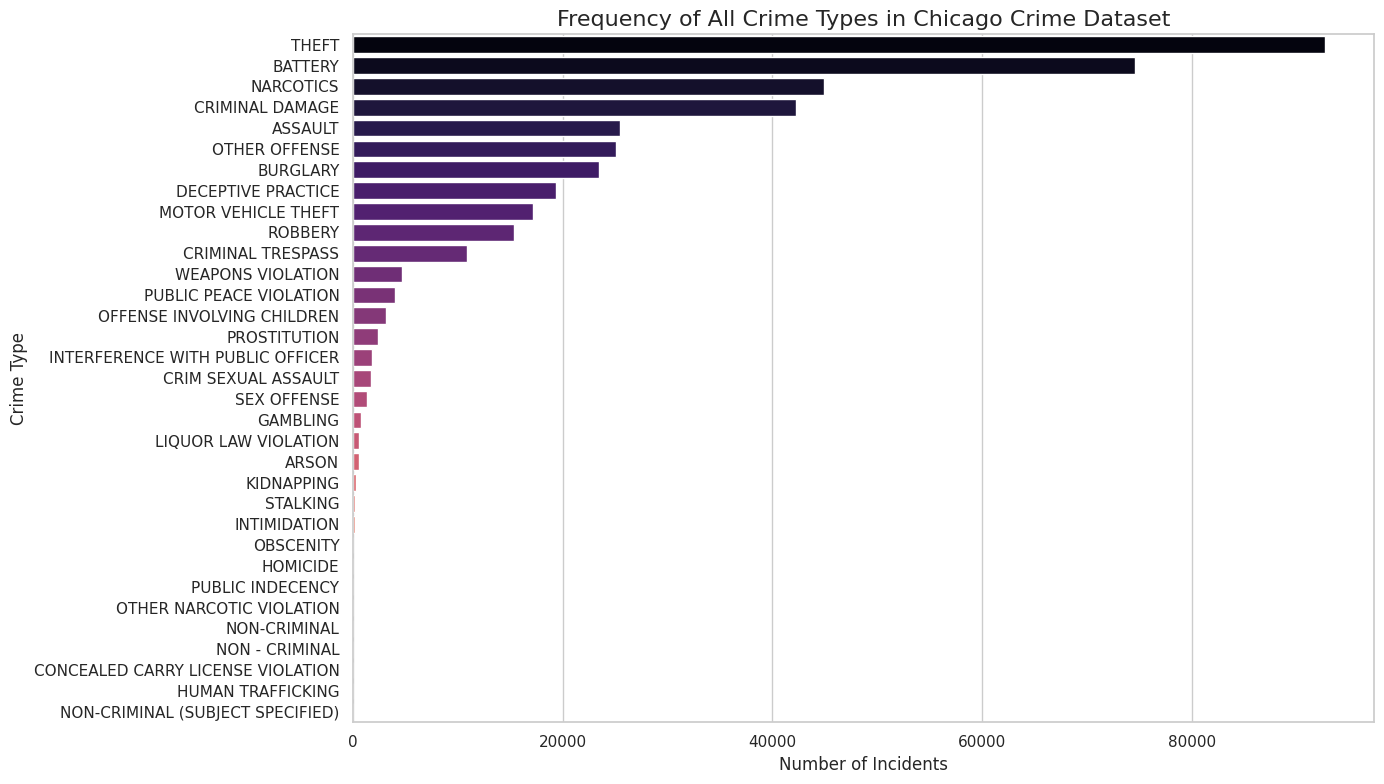

In [ ]:
sns.set(style="whitegrid")
crime_counts = df['Primary Type'].value_counts()
plt.figure(figsize=(14, 8))
sns.barplot(x=crime_counts.values, y=crime_counts.index, hue=crime_counts.index, palette='magma', dodge=False, legend=False)
plt.title('Frequency of All Crime Types in Chicago Crime Dataset', fontsize=16)
plt.ylabel('Crime Type', fontsize=12)
plt.xlabel('Number of Incidents', fontsize=12)
plt.tight_layout()
plt.show()

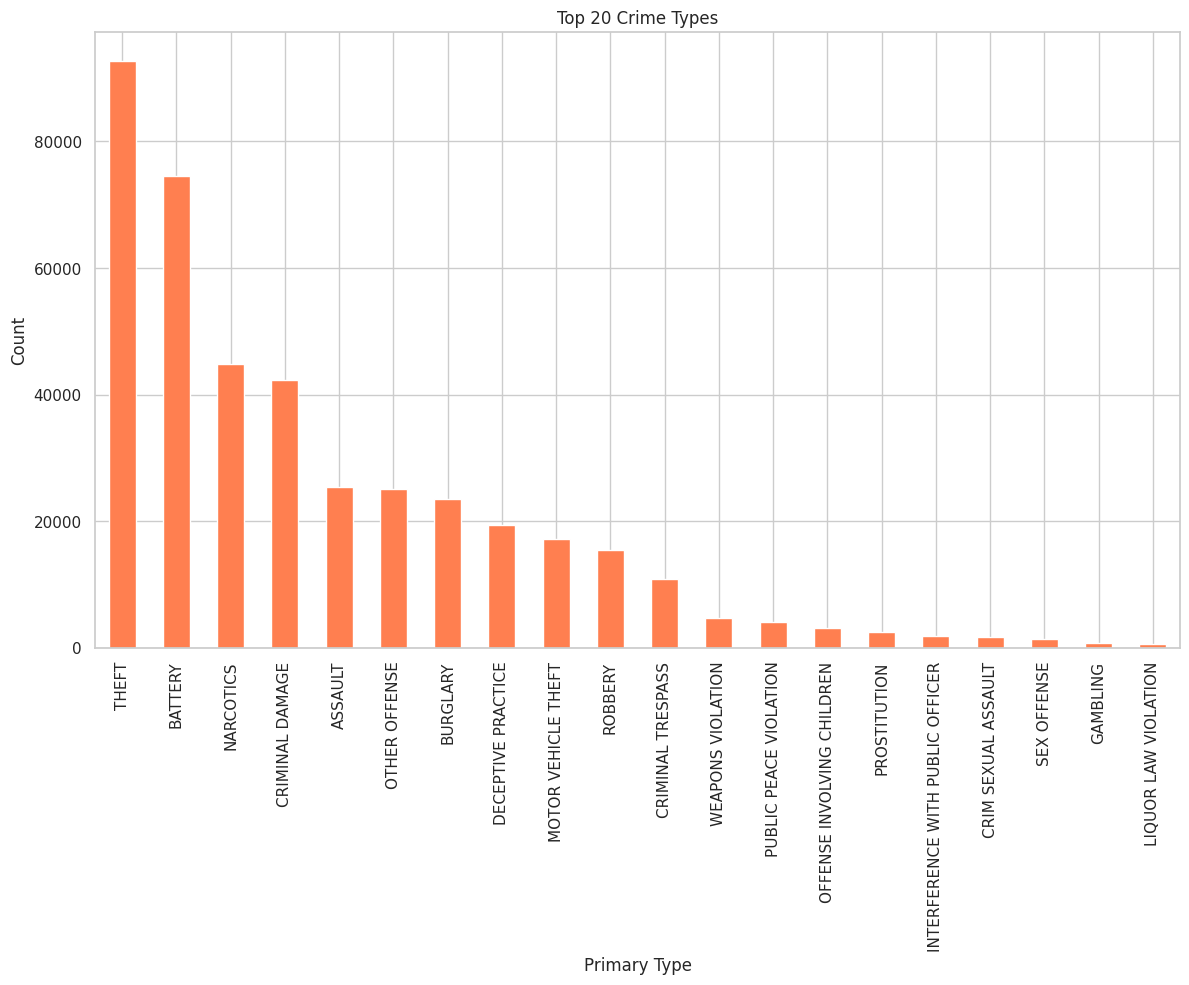

In [ ]:
plt.figure(figsize=(14, 8))
df['Primary Type'].value_counts().head(20).plot(kind='bar', color='coral')
plt.title('Top 20 Crime Types')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

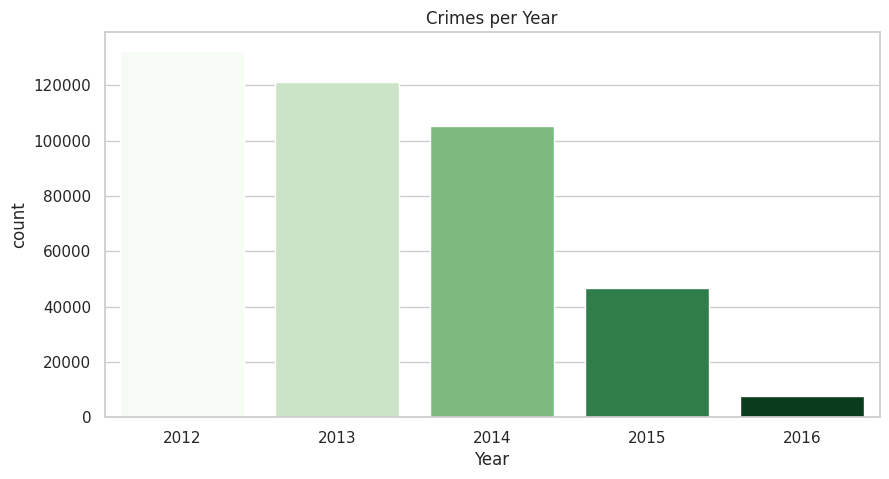

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Year', data=df, palette='Greens', hue='Year', dodge=False, legend=False)
plt.title('Crimes per Year')
plt.show()

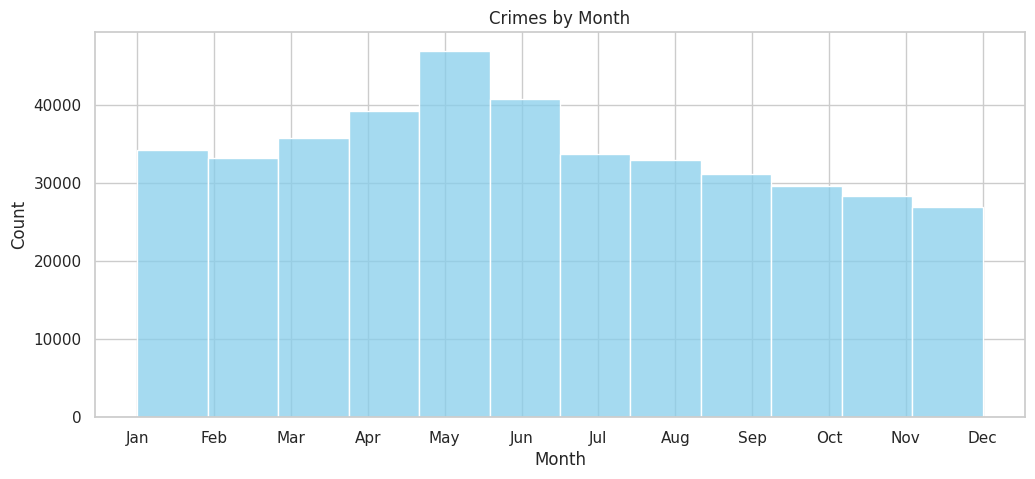

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(df['Month'], bins=12, kde=False, color='skyblue')
plt.title('Crimes by Month')
plt.xlabel('Month')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

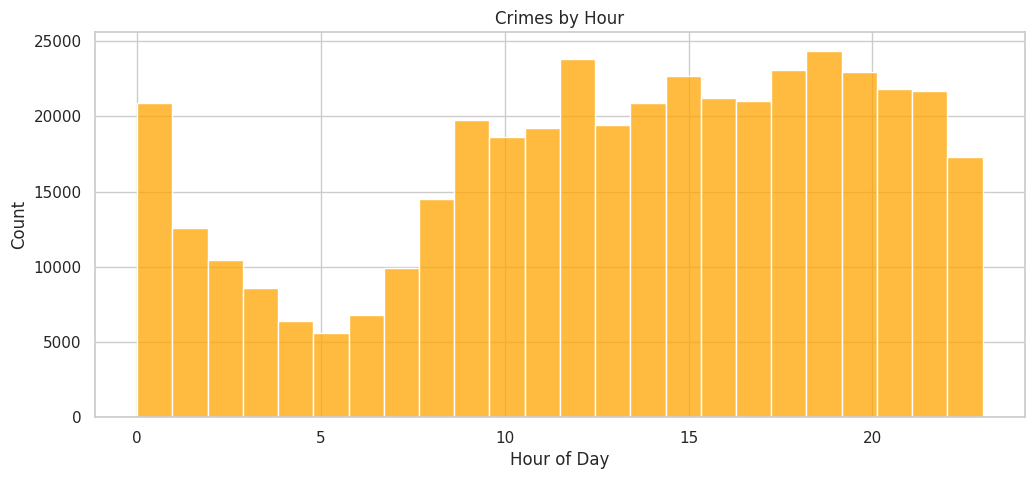

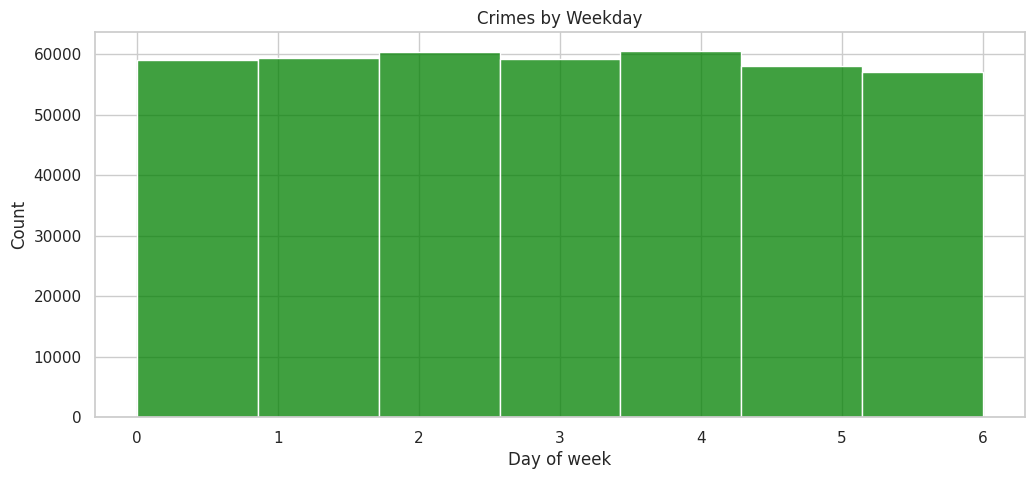

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(df['Hour'], bins=24, kde=False, color='orange')
plt.title('Crimes by Hour')
plt.xlabel('Hour of Day')
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['Weekday'], bins=7, kde=False, color='green')
plt.title('Crimes by Weekday')
plt.xlabel('Day of week')
plt.show()

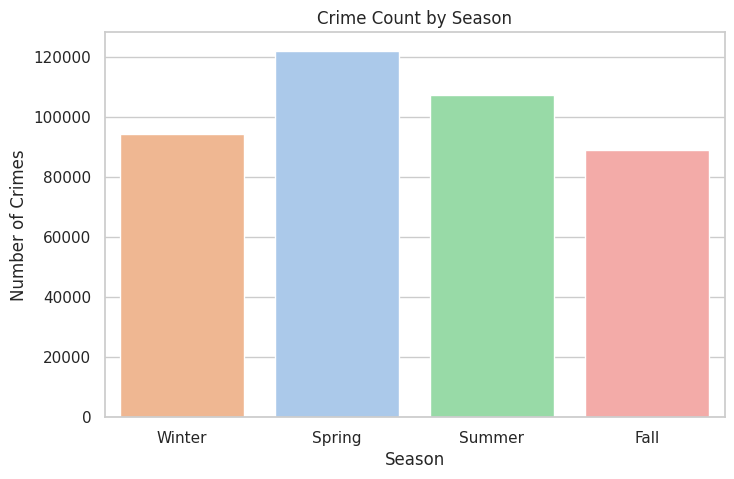

In [ ]:
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['season_name'] = df['Season'].map(season_map)
plt.figure(figsize=(8, 5))
sns.countplot(x='season_name',hue='season_name', data=df, palette='pastel', order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Crime Count by Season')
plt.xlabel('Season')
plt.ylabel('Number of Crimes')
plt.show()

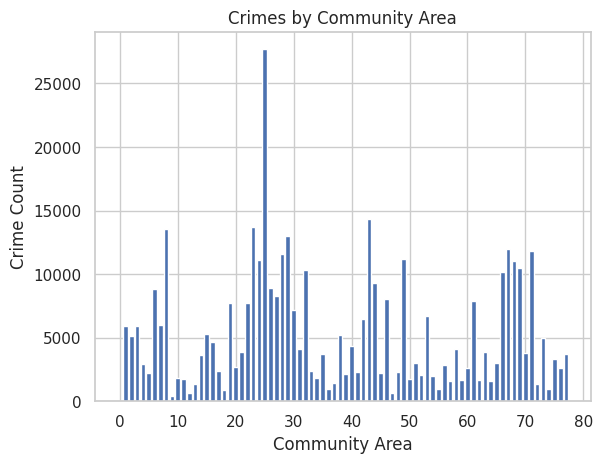

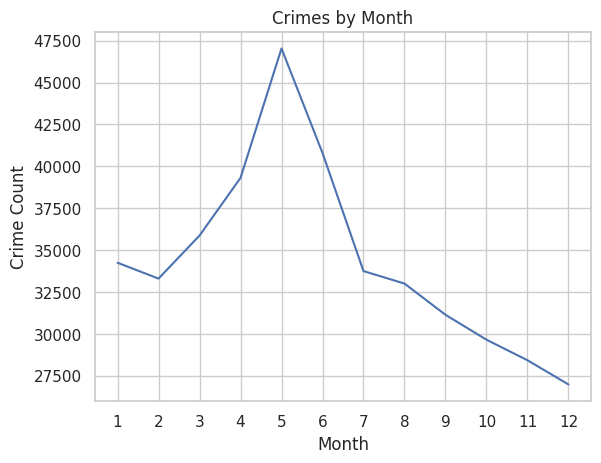

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='epsg:4326')
spatial_aggregation = gdf.groupby('Community Area').size().reset_index(name='CrimeCount')

plt.bar(spatial_aggregation['Community Area'], spatial_aggregation['CrimeCount'])
plt.title('Crimes by Community Area')
plt.xlabel('Community Area')
plt.ylabel('Crime Count')
plt.show()

gdf['Month'] = gdf['Date'].dt.month
temporal_aggregation = gdf.groupby('Month').size().reset_index(name='CrimeCount')
plt.plot(temporal_aggregation['Month'], temporal_aggregation['CrimeCount'])
plt.title('Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.xticks(range(1, 13))
plt.show()

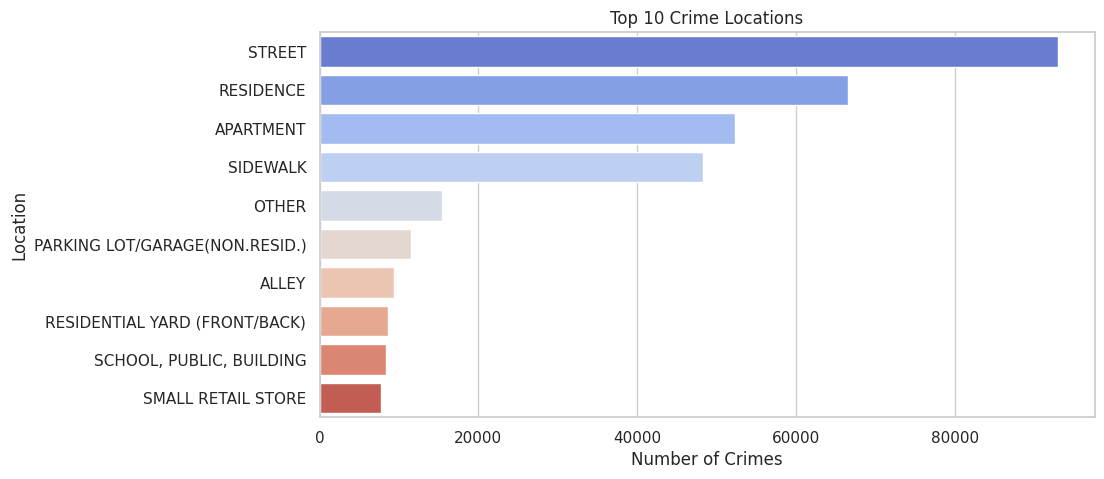

In [ ]:
plt.figure(figsize=(10, 5))
top_locs = df['Location Description'].value_counts().nlargest(10)
sns.barplot(x=top_locs.values, y=top_locs.index,hue=top_locs.index, palette='coolwarm',legend=False )
plt.title('Top 10 Crime Locations')
plt.xlabel('Number of Crimes')
plt.ylabel('Location')
plt.show()

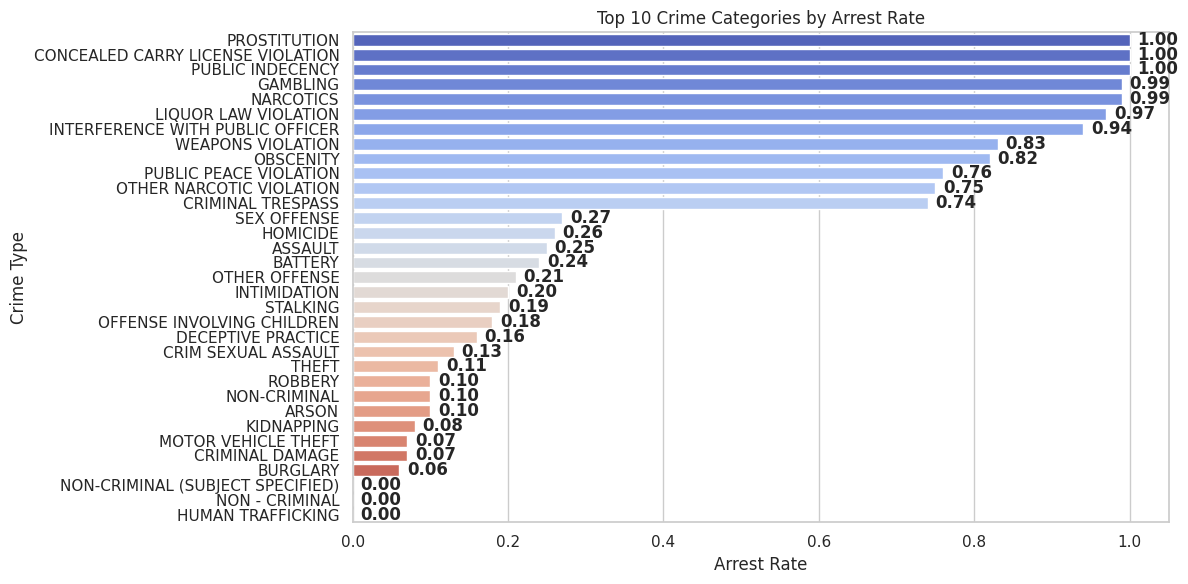

In [ ]:
arrest_rate = df.groupby('Primary Type Encoded')['Arrest'].mean()
arrest_rate_rounded = arrest_rate.round(2)

sorted_indices = arrest_rate_rounded.argsort()[::-1]
sorted_rates = arrest_rate_rounded[sorted_indices]
sorted_crimes = le_primary.inverse_transform(arrest_rate.index[sorted_indices])

plt.figure(figsize=(12, 6))
sns.barplot(
    x=sorted_rates,
    y=sorted_crimes,
    hue=sorted_crimes,
    palette='coolwarm',
    dodge=False,
    legend=False
)

plt.title('Top 10 Crime Categories by Arrest Rate')
plt.xlabel('Arrest Rate')
plt.ylabel('Crime Type')
plt.xlim(0, 1.05)

for i, v in enumerate(sorted_rates):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

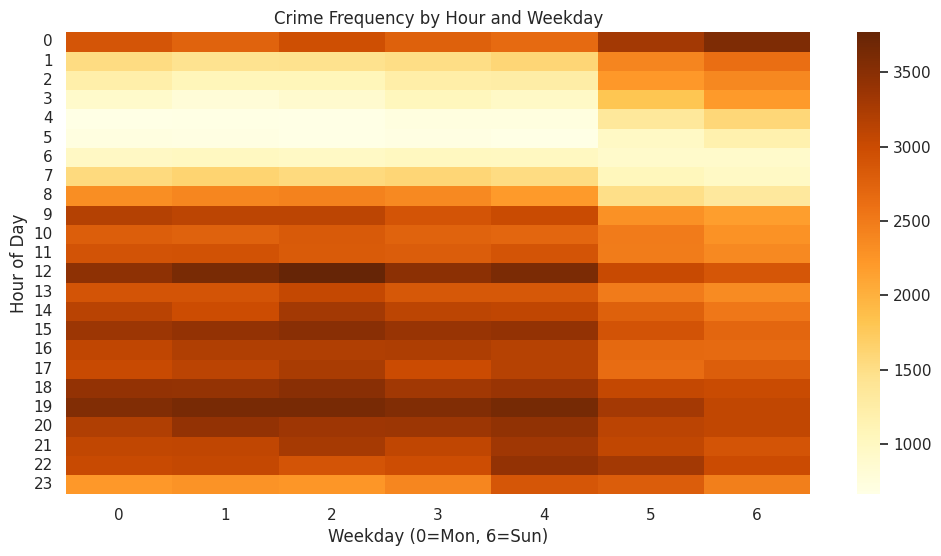

In [ ]:
pivot = df.pivot_table(index='Hour', columns='Weekday', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlOrBr')
plt.title('Crime Frequency by Hour and Weekday')
plt.xlabel('Weekday (0=Mon, 6=Sun)')
plt.ylabel('Hour of Day')
plt.show()